<a href="https://colab.research.google.com/github/hmtu14/HappyWhale/blob/main/effnet_b0_with_fullbody_progressive_resizing_fold4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The goal of this notebook is to extend upon the work of [MANOJ PRABHAKAR](https://www.kaggle.com/manojprabhaakr) in the [EFFNET B6 WHALE COMP](https://www.kaggle.com/manojprabhaakr/effnet-b6-whale-comp), utilising the [Detic bounding boxes](https://www.kaggle.com/c/happy-whale-and-dolphin/discussion/305503) to precrop the images.

I have created a new set of TFRecords which includes the bounding boxes in [this](https://www.kaggle.com/lextoumbourou/happywhale-tfrecords-with-bounding-boxes) repo.

At the time of creation, this notebook achieves a top 100 score. Given there's still 2 months left in the competition and that this data is all publically available, I felt it to be reasonable to release.

In [1]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.57.12.98:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.57.12.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.12.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [2]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime

## Config

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
save_dir = '.'
save_dir = "/content/drive/MyDrive/Kaggle/HappyWhale-2022/B6_resizing"
EXPERIMENT = 4
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)

20220404-025450


In [5]:
GCS_DS_PATH = 'gs://kds-83285b2df5c0ef10fcd617d0c5487f7ea3775df75025c04df057d16e'

In [6]:
class config:
    SEED = 42
    FOLD_TO_RUN = EXPERIMENT
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 224
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 0
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 8
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 100
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [7]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b0


In [8]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [9]:
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_DS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_DS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_DS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-83285b2df5c0ef10fcd617d0c5487f7ea3775df75025c04df057d16e
10 10 51033 27956


## Data

In [10]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
# Updated to include crops.
def decode_image(image_data, box):
    if box is not None and box[0] != -1:
        left, top, right, bottom = box[0], box[1], box[2], box[3]
        bbs = tf.convert_to_tensor([top, left, bottom - top, right - left])
        image = tf.io.decode_and_crop_jpeg(image_data, bbs, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels = 3)

    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
        'fullbody_bb': tf.io.FixedLenFeature([4], tf.int64),
        # 'detic_box': tf.io.FixedLenFeature([4], tf.int64),
         # 'yolov5_box': tf.io.FixedLenFeature([4], tf.int64),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    # bb = tf.cast(example['detic_box'], tf.int32)
    bb = tf.cast(example['fullbody_bb'], tf.int32)
    image = decode_image(example['image'], bb)
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

51033


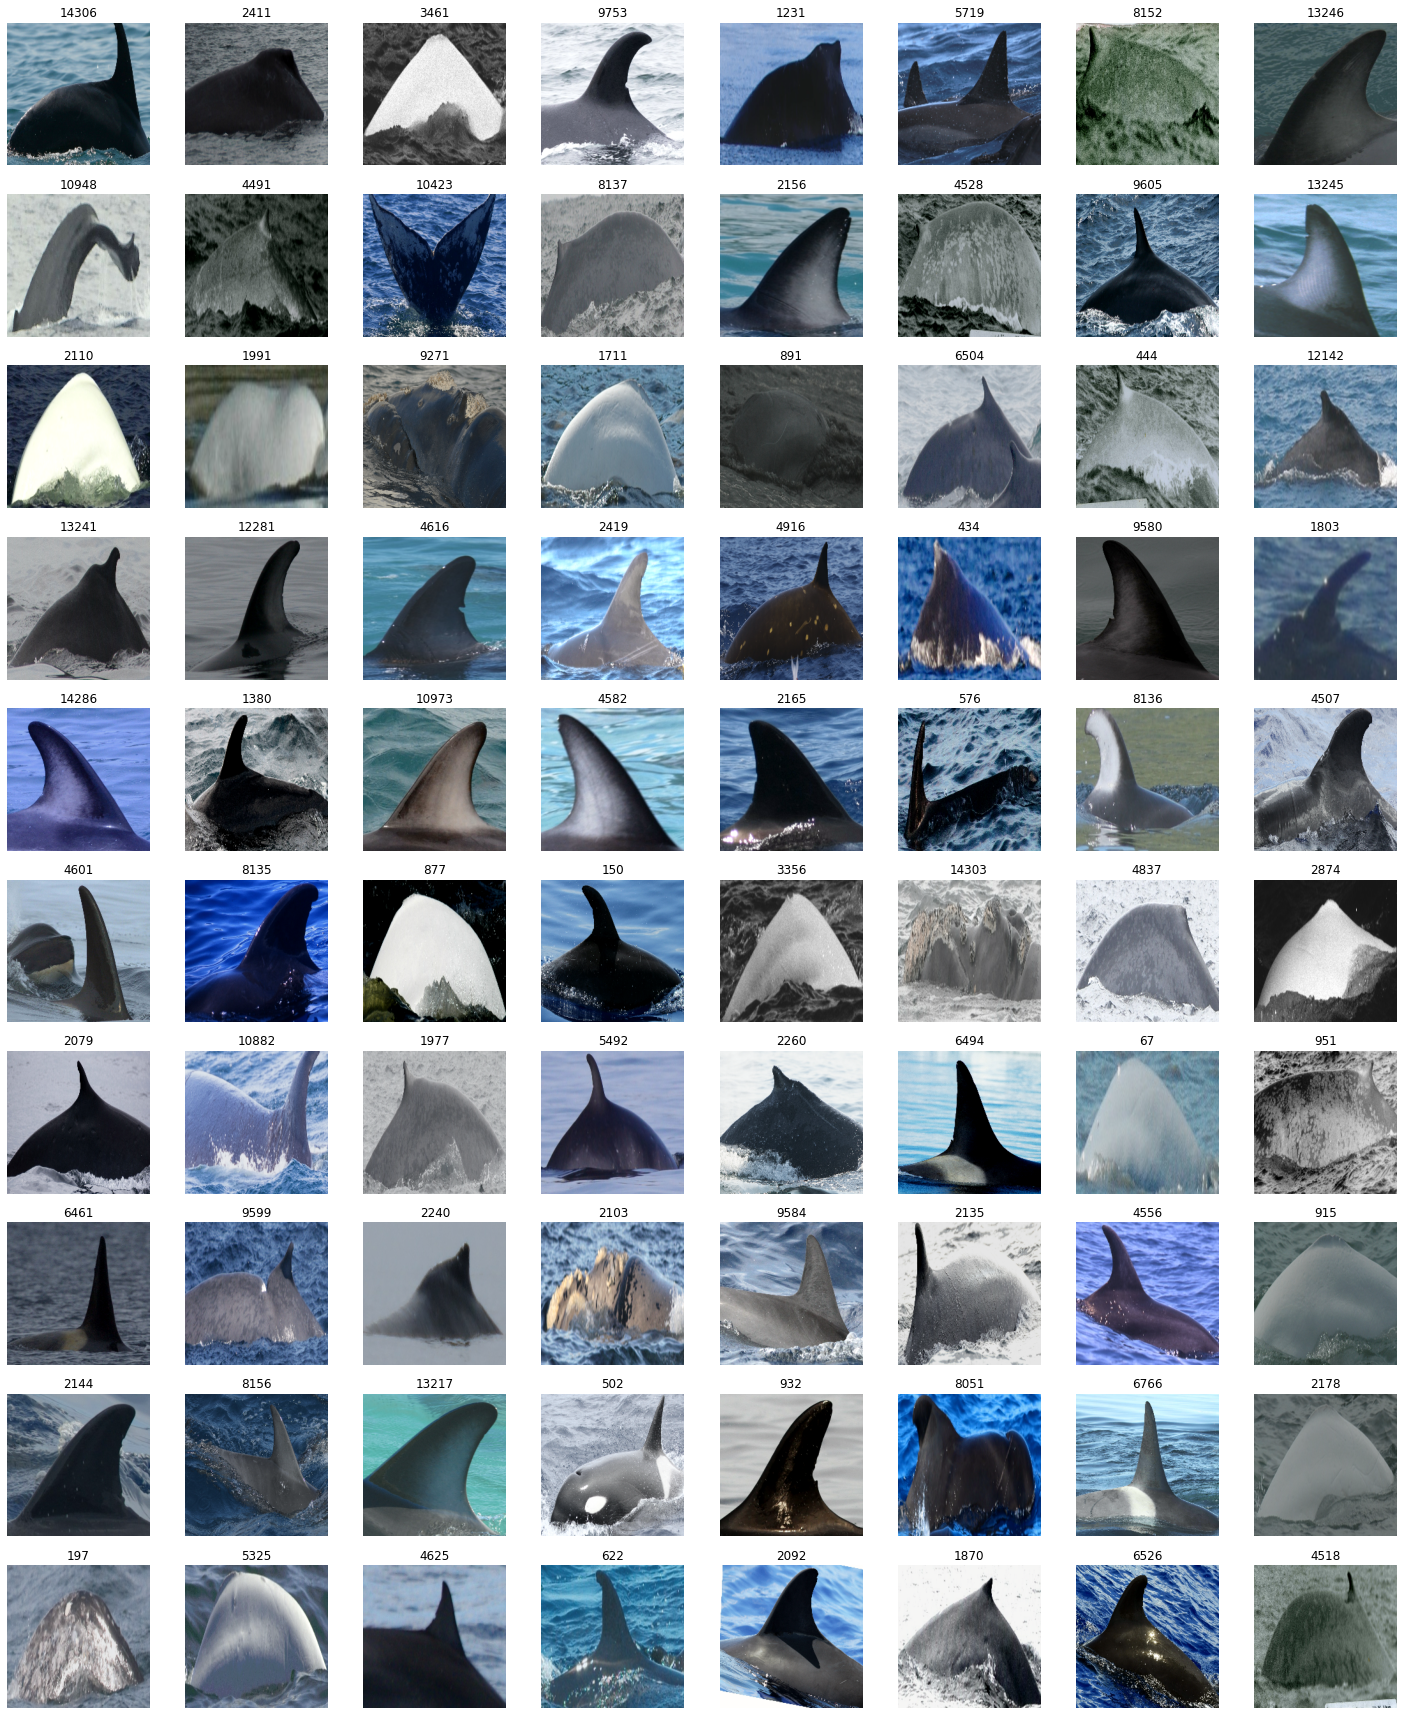

(128, 224, 224, 3)


In [11]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

27956


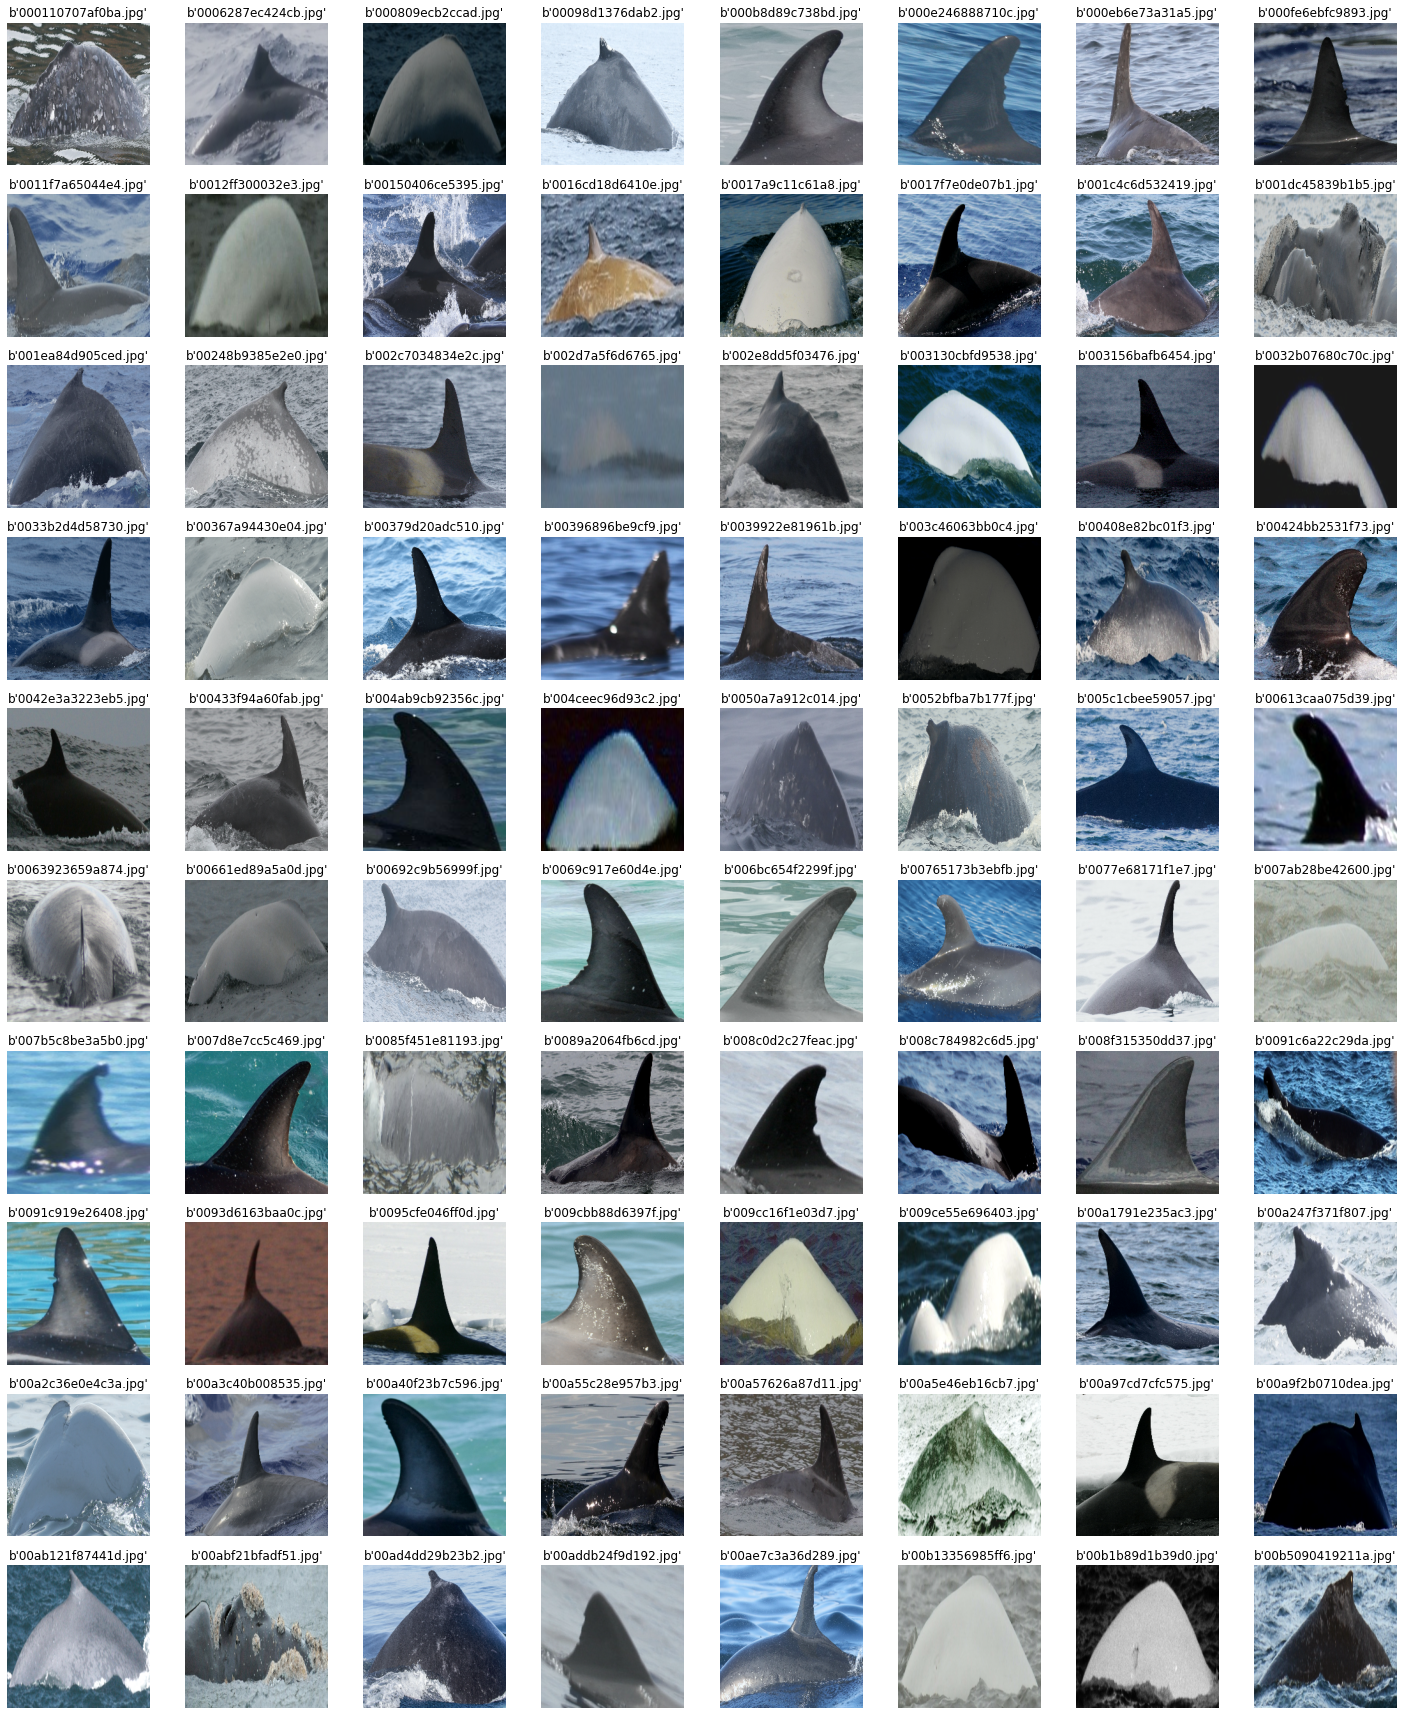

(128, 224, 224, 3)


In [12]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

## Model

In [13]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

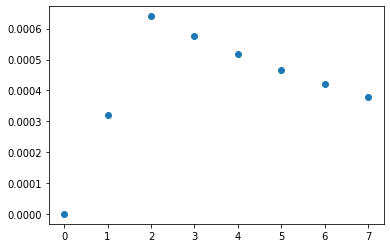

In [14]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 2
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [15]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin1 = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head1/{config.head}', 
            dtype='float32'
            )
        margin2 = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.25, 
            name=f'head2/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        backbone = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
        embed1 = tf.keras.layers.GlobalAveragePooling2D()(backbone)
        # embed2 = tf.keras.layers.GlobalMaxPooling2D()(backbone)
        
#         embed1 = tf.keras.layers.Dropout(0.2)(embed1)
#         embed1 = tf.keras.layers.Dense(512)(embed1)
        
        # embed2 = tf.keras.layers.Dense(512)(embed2)
        
        # embed1 = tf.keras.layers.concatenate([embed1, embed2])
        x1 = margin1([embed1, label])
        
        output1 = tf.keras.layers.Softmax(dtype='float32')(x1)
        
        # embed2 = tf.keras.layers.Dropout(0.2)(embed2)
        # embed2 = tf.keras.layers.GlobalMaxPooling2D()(backbone.get_layer('block7b_project_bn').output)
        # embed2 = tf.keras.layers.GlobalMaxPooling2D()(backbone)
        # embed2 = tf.keras.layers.Dense(512)(embed2)
        # x2 = margin2([embed2, label])
        
        # output2 = tf.keras.layers.Softmax(dtype='float32')(x2)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = output1)
        
        # average_embed = tf.keras.layers.Average()([embed1, embed2])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed1)
        
        opt = tf.keras.optimizers.Adam(learning_rate=config.LR)
        opt = tfa.optimizers.SWA(opt, start_averaging=4650, average_period=310)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)
        
#         losses = {
#         "category_output": "categorical_crossentropy",
#         "color_output": "categorical_crossentropy",
#         }
        # lossWeights = {"category_output": 1.0, "color_output": 1.0}

        model.compile(
            optimizer = opt,
            loss = [# tf.keras.losses.SparseCategoricalCrossentropy(),
                   tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

In [16]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Train

In [17]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 40827 10206


In [18]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [19]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:   
    model.load_weights(config.resume_model_wts)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b0 (Functional)   (None, None, None,   4049564     ['inp1[0][0]']                   
                                1280)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnet-b0[0][0]']        
 alAveragePooling2D)                                                                          

In [20]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)

#### Image Size 224 with EfficientNet B0 and batch_size 128
Epoch 1/8
  6/318 [..............................] - ETA: 31s - loss: 18.8429 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0080s vs `on_train_batch_end` time: 13.6983s). Check your callbacks.


318/318 [==============================] - 242s 341ms/step - loss: 18.8141 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.8228 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/8
318/318 [==============================] - 58s 182ms/step - loss: 16.1687 - sparse_categorical_accuracy: 1.2284e-04 - sparse_top_k_categorical_accuracy: 4.1765e-04 - val_loss: 15.8588 - val_sparse_categorical_accuracy: 0.0019 - val_sparse_top_k_categorical_accuracy: 0.0045 - lr: 3.2050e-04
Epoch 3/8
318/318 [==============================] - 53s 168ms/step - loss: 13.3260 - sparse_categorical_accuracy: 0.0035 - sparse_top_k_categorical_accuracy: 0.0086 - val_loss: 14.9061 - val_sparse_categorical_accuracy: 0.0106 - val_sparse_top_k_categorical_accuracy: 0.0172 - lr: 6.4000e-04
Epoch 4/8
318/318 [==============================] - 50s 158ms/step - loss: 9.8864 - sparse_categorical_ac

In [21]:
VERBOSE = 1
config.IMAGE_SIZE = 448

train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b0 (Functional)   (None, None, None,   4049564     ['inp1[0][0]']                   
                                1280)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnet-b0[0][0]']        
 alAveragePooling2D)                                                                          

318/318 [==============================] - 282s 459ms/step - loss: 10.0957 - sparse_categorical_accuracy: 0.0103 - sparse_top_k_categorical_accuracy: 0.0276 - val_loss: 14.0388 - val_sparse_categorical_accuracy: 0.0196 - val_sparse_top_k_categorical_accuracy: 0.0416 - lr: 1.0000e-06
Epoch 2/8
318/318 [==============================] - 124s 390ms/step - loss: 5.4965 - sparse_categorical_accuracy: 0.1960 - sparse_top_k_categorical_accuracy: 0.3678 - val_loss: 12.4163 - val_sparse_categorical_accuracy: 0.0833 - val_sparse_top_k_categorical_accuracy: 0.1355 - lr: 3.2050e-04
Epoch 3/8
318/318 [==============================] - 128s 402ms/step - loss: 4.5394 - sparse_categorical_accuracy: 0.3414 - sparse_top_k_categorical_accuracy: 0.4887 - val_loss: 12.2808 - val_sparse_categorical_accuracy: 0.0850 - val_sparse_top_k_categorical_accuracy: 0.1442 - lr: 6.4000e-04
Epoch 4/8
318/318 [==============================] - 129s 404ms/step - loss: 3.5727 - sparse_categorical_accuracy: 0.4455 - sparse

In [23]:
config.IMAGE_SIZE = 512
config.BATCH_SIZE = 8 * strategy.num_replicas_in_sync

VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss], 
                verbose = VERBOSE)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b0 (Functional)   (None, None, None,   4049564     ['inp1[0][0]']                   
                                1280)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnet-b0[0][0]']        
 alAveragePooling2D)                                                                          

637/637 [==============================] - 342s 319ms/step - loss: 3.3570 - sparse_categorical_accuracy: 0.3692 - sparse_top_k_categorical_accuracy: 0.6298 - val_loss: 11.0603 - val_sparse_categorical_accuracy: 0.1859 - val_sparse_top_k_categorical_accuracy: 0.2600 - lr: 1.0000e-06
Epoch 2/8
637/637 [==============================] - 153s 240ms/step - loss: 2.1939 - sparse_categorical_accuracy: 0.6167 - sparse_top_k_categorical_accuracy: 0.7866 - val_loss: 11.0128 - val_sparse_categorical_accuracy: 0.1871 - val_sparse_top_k_categorical_accuracy: 0.2637 - lr: 1.6050e-04
Epoch 3/8
637/637 [==============================] - 151s 237ms/step - loss: 2.3310 - sparse_categorical_accuracy: 0.5960 - sparse_top_k_categorical_accuracy: 0.7682 - val_loss: 11.1177 - val_sparse_categorical_accuracy: 0.1761 - val_sparse_top_k_categorical_accuracy: 0.2513 - lr: 3.2000e-04
Epoch 4/8
637/637 [==============================] - 150s 235ms/step - loss: 2.0628 - sparse_categorical_accuracy: 0.6399 - sparse_

In [24]:
config.IMAGE_SIZE = 768
config.BATCH_SIZE = 8 * strategy.num_replicas_in_sync

VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [snap,get_lr_callback(),train_logger,sv_loss],
                verbose = VERBOSE)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b0 (Functional)   (None, None, None,   4049564     ['inp1[0][0]']                   
                                1280)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnet-b0[0][0]']        
 alAveragePooling2D)                                                                          

637/637 [==============================] - 447s 469ms/step - loss: 4.2736 - sparse_categorical_accuracy: 0.2548 - sparse_top_k_categorical_accuracy: 0.4958 - val_loss: 11.3021 - val_sparse_categorical_accuracy: 0.1619 - val_sparse_top_k_categorical_accuracy: 0.2402 - lr: 1.0000e-06
Epoch 2/8
637/637 [==============================] - 288s 453ms/step - loss: 1.8461 - sparse_categorical_accuracy: 0.6663 - sparse_top_k_categorical_accuracy: 0.8352 - val_loss: 10.7529 - val_sparse_categorical_accuracy: 0.2133 - val_sparse_top_k_categorical_accuracy: 0.2982 - lr: 1.6050e-04
Epoch 3/8
637/637 [==============================] - 285s 447ms/step - loss: 1.7541 - sparse_categorical_accuracy: 0.6799 - sparse_top_k_categorical_accuracy: 0.8410 - val_loss: 10.8125 - val_sparse_categorical_accuracy: 0.1985 - val_sparse_top_k_categorical_accuracy: 0.2856 - lr: 3.2000e-04
Epoch 4/8
637/637 [==============================] - 286s 450ms/step - loss: 1.4981 - sparse_categorical_accuracy: 0.7276 - sparse_

In [25]:
model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss.h5")

## Evaluation

In [26]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('/content/drive/MyDrive/Kaggle/HappyWhale-2022/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [27]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [29]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2173
37c7aba965a5        80
114207cab555        37
600ab1de92d9        35
b9907151f66e        34
                  ... 
7aa63b94cde7         1
a1fdc77441b3         1
f84380c70c43         1
29890ab99444         1
cb979f5b7e4a         1
Name: target, Length: 3194, dtype: int64

In [31]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10206 [00:00<?, ?it/s]

1      453
22     179
20     174
23     159
16     159
      ... 
96      47
98      43
99      41
97      37
100     27
Name: image, Length: 100, dtype: int64

In [32]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.0: 0.6390032007315908


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.1: 0.6390032007315908


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.2: 0.6390032007315908


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.6391501731007854


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.4: 0.6597263047880277


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.5: 0.7066594813508331


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.6855444509765438


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.6358187993990413


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.8: 0.5823698478019429


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 0.9: 0.5259814488209527


0it [00:00, ?it/s]

  0%|          | 0/10206 [00:00<?, ?it/s]

CV at threshold 1.0: 0.4916878960088821


In [33]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.5
Best cv 0.7066594813508331


0.0           0.1           0.2  0.30000000000000004  \
count  10206.000000  10206.000000  10206.000000         10206.000000   
mean       0.639003      0.639003      0.639003             0.639150   
std        0.399826      0.399826      0.399826             0.399867   
min        0.000000      0.000000      0.000000             0.000000   
25%        0.333333      0.333333      0.333333             0.333333   
50%        1.000000      1.000000      1.000000             1.000000   
75%        1.000000      1.000000      1.000000             1.000000   
max        1.000000      1.000000      1.000000             1.000000   

                0.4           0.5  0.6000000000000001  0.7000000000000001  \
count  10206.000000  10206.000000        10206.000000        10206.000000   
mean       0.659726      0.706659            0.685544            0.635819   
std        0.405009      0.412679            0.409912            0.398928   
min        0.000000      0.000000            0.000000            0.000000   
25%        0.333333      0.333333            0.333333            0.333333   
50%        1.000000      1.000000            1.000000            1.000000   
75%        1.000000      1.000000            1.000000            1.000000   
max        1.000000      1.000000            1.000000            1.000000   

                0.8           0.9           1.0  
count  10206.000000  10206.000000  10206.000000  
mean       0.582370      0.525981      0.491688  
std        0.379579      0.349275      0.324732  
min        0.000000      0.000000      0.000000  
25%        0.333333      0.333333      0.333333  
50%        0.500000      0.500000      0.500000  
75%        1.000000      1.000000      0.500000  
max        1.000000      1.000000      1.000000

In [34]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8033, True: 2173}
best_threshold 0.5


is_new_individual       False      True  adjusted_cv
0.0                  0.676605  0.500000     0.658944
0.1                  0.676605  0.500000     0.658944
0.2                  0.676605  0.500000     0.658944
0.30000000000000004  0.676605  0.500690     0.659013
0.4                  0.675173  0.602623     0.667918
0.5                  0.653637  0.902669     0.678540
0.6000000000000001   0.604029  0.986884     0.642315
0.7000000000000001   0.537927  0.997699     0.583904
0.8                  0.469584  0.999310     0.522556
0.9                  0.397755  1.000000     0.457980
1.0                  0.354185  1.000000     0.418766

## Inference

In [ ]:
# train_embeddings = np.concatenate([train_embeddings,val_embeddings])
# train_targets = np.concatenate([train_targets,val_targets])
# print(train_embeddings.shape,train_targets.shape)

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
# neigh.fit(train_embeddings)

In [ ]:
# test_ids = []
# test_nn_distances = []
# test_nn_idxs = []
# for filename in tqdm(test_files):
#     embeddings = get_embeddings(filename)
#     ids = get_ids(filename)
#     distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
#     test_ids.append(ids)
#     test_nn_idxs.append(idxs)
#     test_nn_distances.append(distances)
# test_nn_distances = np.concatenate(test_nn_distances)
# test_nn_idxs = np.concatenate(test_nn_idxs)
# test_ids = np.concatenate(test_ids)

In [ ]:
# sample_submission = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv',index_col='image')
# print(len(test_ids),len(sample_submission))
# test_df = []
# for i in tqdm(range(len(test_ids))):
#     id_ = test_ids[i]
#     targets = train_targets[test_nn_idxs[i]]
#     distances = test_nn_distances[i]
#     subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
#     subset_preds['image'] = id_
#     test_df.append(subset_preds)
# test_df = pd.concat(test_df).reset_index(drop=True)
# test_df['confidence'] = 1-test_df['distances']
# test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
# test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
# test_df['target'] = test_df['target'].map(target_encodings)
# test_df.to_csv('test_neighbors.csv')
# test_df.image.value_counts().value_counts()

In [ ]:
# sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
# predictions = {}
# for i,row in tqdm(test_df.iterrows()):
#     if row.image in predictions:
#         if len(predictions[row.image])==5:
#             continue
#         predictions[row.image].append(row.target)
#     elif row.confidence>best_threshold_adjusted:
#         predictions[row.image] = [row.target,'new_individual']
#     else:
#         predictions[row.image] = ['new_individual',row.target]
        
# for x in tqdm(predictions):
#     if len(predictions[x])<5:
#         remaining = [y for y in sample_list if y not in predictions]
#         predictions[x] = predictions[x]+remaining
#         predictions[x] = predictions[x][:5]
#     predictions[x] = ' '.join(predictions[x])
    
# predictions = pd.Series(predictions).reset_index()
# predictions.columns = ['image','predictions']
# predictions.to_csv('submission.csv',index=False)
# predictions.head()